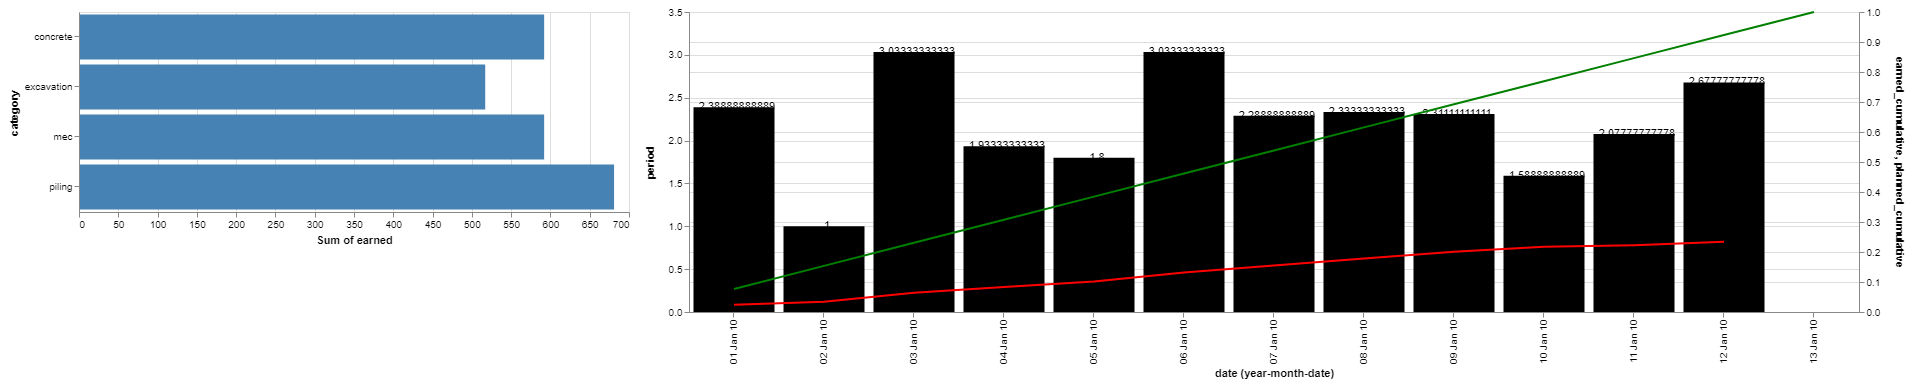

In [3]:
import altair as alt

path='https://raw.githubusercontent.com/djouallah/vega-lite/master/data/earned.csv'
df = alt.UrlData(url=path, format=alt.CsvDataFormat(parse={'date': 'date:"%e/%m/%Y"'}))
pts = alt.selection(type='multi', encodings=['y'])

barselect = alt.Chart(df).mark_bar().encode(
    y='category:N',
    x='sum(earned):Q',
    color=alt.condition(pts, alt.ColorValue("steelblue"), alt.ColorValue("grey"))
).properties(
    selection=pts,
    width=550,
    height=200
)   
  
line_earned = alt.Chart(df).transform_filter(
    pts
      ).transform_aggregate(
    sum_installed_cumulative='sum(earned_cumulative)',
    sum_planned_cumulative='sum(planned_cumulative)',
    sum_budget='sum(budget)',
    sum_Installed_qty='sum(earned)',
    groupby=['date']
).transform_calculate(
    earned_cumulative='datum.sum_installed_cumulative / datum.sum_budget',
    planned_cumulative='datum.sum_planned_cumulative / datum.sum_budget',
    period='datum.sum_Installed_qty/ datum.sum_budget*100'
).mark_line(color='red').encode(
    x=alt.X("date:O", timeUnit="yearmonthdate",axis=alt.Axis(format="%d %b %y")),
    y='earned_cumulative:Q'
)
bar= line_earned.mark_bar(color='black').encode(
        y='period:Q'
)  
line_planned= line_earned.mark_line(color="green").encode(
        y='planned_cumulative:Q'
)  
text = bar.mark_text(
    align='center',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
                ).encode(text='period:Q') 

combo = alt.layer(
    bar+ text,
    line_earned+line_planned
     ).resolve_scale(y='independent')
    
    
chart= alt.hconcat(
    barselect,
    combo
).resolve_legend(
    color="independent",
    size="independent"
)
chart.save('docs/index.html')
chart